[Loading training data...]
[Loading holdout data...]
[Data loaded]
  Training TG tensor: torch.Size([1355, 50789]) (n_cells, n_genes)
  Holdout TG tensor:  torch.Size([617, 3470])

[Aligning TG indices...]
  Aligned genes: 592
  Training aligned shape: (1355, 592)
  Holdout aligned shape:  (617, 592)

GLOBAL STATISTICS

Training Data:
  Mean:   0.084112  |  Holdout: 0.231627  |  Δ: 0.147515
  Std:    0.255837  |  Holdout: 0.402650  |  Ratio: 1.5739
  Median: 0.000000  |  Holdout: 0.065946  |  Δ: 0.065946
  Min:    0.000000  |  Holdout: 0.000000
  Max:    4.252219  |  Holdout: 5.122061

PER-GENE STATISTICS

Mean differences (holdout - training):
  Mean:   0.147515
  Median: 0.151571
  Std:    0.030547
  Min:    0.025384
  Max:    0.225266
  MAE:    0.147515

Std ratios (holdout / training):
  Mean:   1.6005
  Median: 1.5510
  Min:    0.9465
  Max:    2.7122

Genes with large shifts (>1 std from median):
  Mean shift: 591 / 592
  Std shift:  550 / 592

STATISTICAL TESTS

Kolmogorov-Smirn

/tmp/ipykernel_1352188/2294860980.py:261: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([mesc_training_tg_tensor_aligned.flatten(),


Saved: distribution_comparison.png


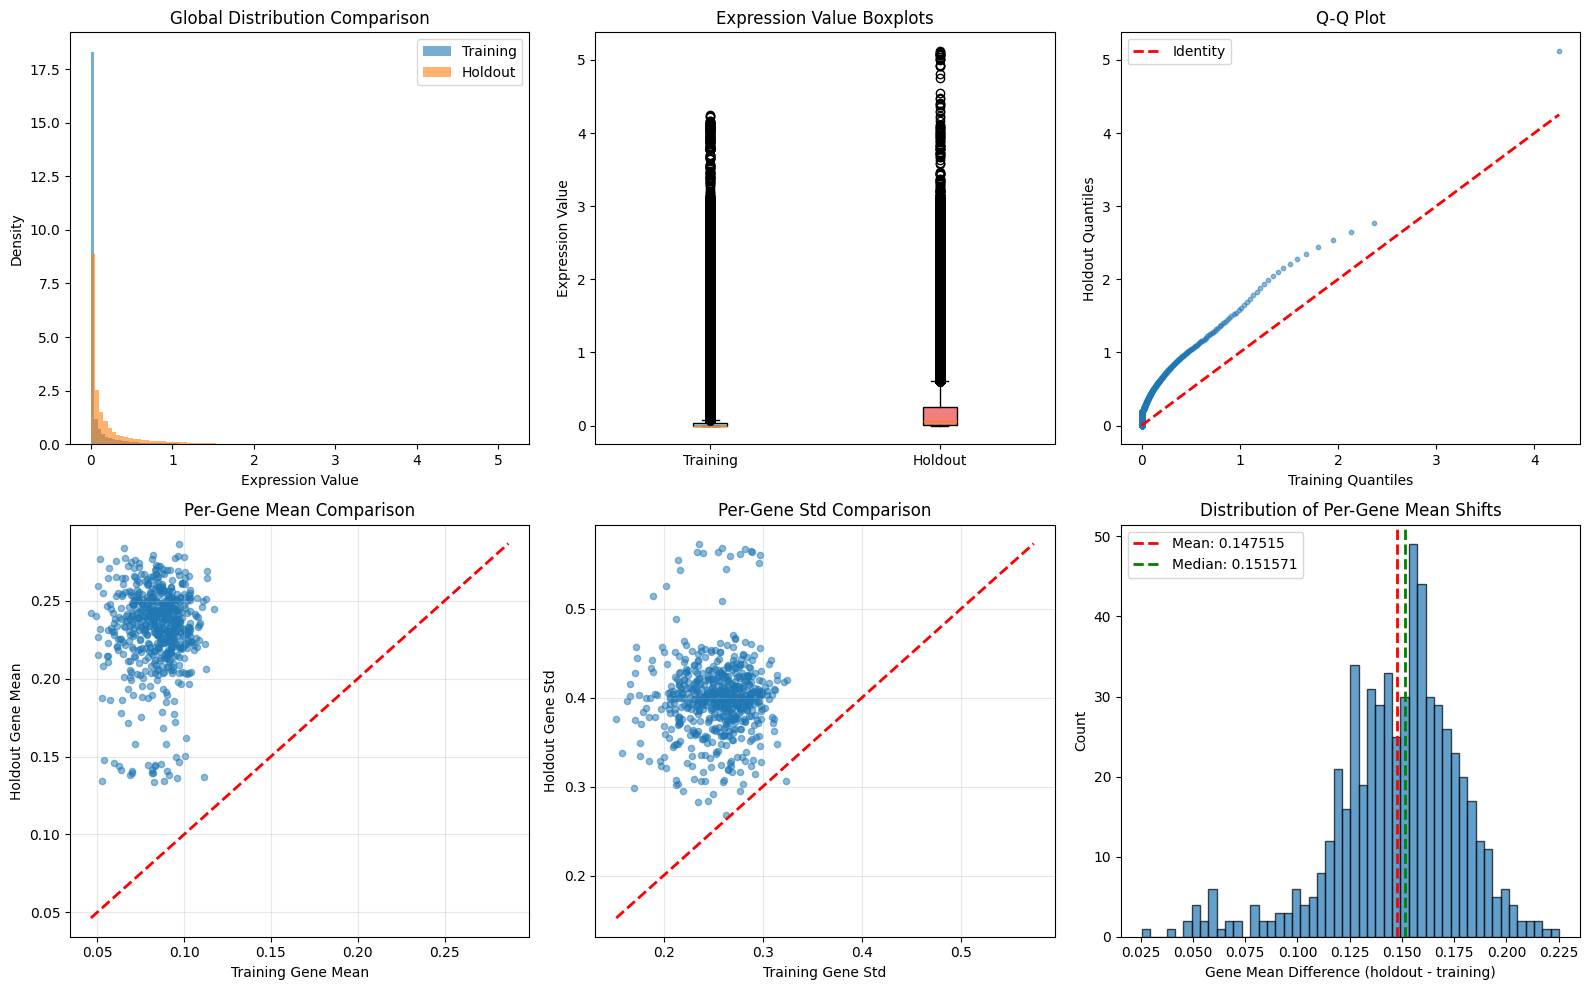


CORRELATION ANALYSIS

Pearson correlation of per-gene means: 0.024029
Spearman correlation of per-gene means: -0.025731
Pearson correlation of per-gene stds: 0.053461

SUMMARY & INTERPRETATION

Distribution Shift Severity:
  Mean shift (as fraction of training std): 0.5766
  Std shift (mean |ratio - 1.0|):          0.6007

⚠️  DISTRIBUTIONS ARE SIGNIFICANTLY DIFFERENT (KS test p < 0.05)
   This explains 57.7% of performance drop

Expected Impact on Model Performance:
  HIGH: Distribution shift may significantly impact performance



In [ ]:
"""
Comprehensive analysis comparing training vs holdout data distributions.
Helps identify if distribution shift explains model performance degradation.
"""

import json
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

# ============================================================================
# SETUP
# ============================================================================

def load_chrom_tg_ids_and_tensor(chrom_ids, cache_path):
    """Load TG IDs, tensors, and names across all chromosomes."""
    chrom_tg_ids = []
    chrom_tensors = []
    chrom_tg_names = []
    
    for chrom in chrom_ids:
        tg_ids = torch.load(os.path.join(cache_path, chrom, f"tg_ids_{chrom}.pt"))
        tg_tensor = torch.load(os.path.join(cache_path, chrom, f"tg_tensor_all_{chrom}.pt"))
        with open(os.path.join(cache_path, chrom, f"tg_names_{chrom}.json"), "r") as f:
            tg_names = json.load(f)
        
        chrom_tg_ids.append(tg_ids)
        chrom_tensors.append(tg_tensor)
        for name in tg_names:
            chrom_tg_names.append(name)
    
    full_tg_ids = torch.cat(chrom_tg_ids)
    full_tg_tensor = torch.cat(chrom_tensors)
    
    return full_tg_ids, full_tg_tensor, chrom_tg_names


# ============================================================================
# LOAD DATA
# ============================================================================

HOLDOUT_DATA_CACHE = "data/training_data_cache/mESC_holdout"
TRAINING_DATA_CACHE = Path("data/training_data_cache/mESC_no_scale_linear")

print("[Loading training data...]")
mesc_training_tf_ids = torch.load(os.path.join(TRAINING_DATA_CACHE, "tf_ids.pt"))
mesc_training_tf_tensor = torch.load(os.path.join(TRAINING_DATA_CACHE, "tf_tensor_all.pt"))
with open(os.path.join(TRAINING_DATA_CACHE, "tf_names.json"), "r") as f:
    mesc_training_tf_names = json.load(f)

mesc_training_tg_ids, mesc_training_tg_tensor, mesc_training_tg_names = load_chrom_tg_ids_and_tensor(
    CHROM_IDS, TRAINING_DATA_CACHE
)

print("[Loading holdout data...]")
mesc_holdout_tf_ids = torch.load(os.path.join(HOLDOUT_DATA_CACHE, "tf_ids.pt"))
mesc_holdout_tf_tensor = torch.load(os.path.join(HOLDOUT_DATA_CACHE, "tf_tensor_all.pt"))
with open(os.path.join(HOLDOUT_DATA_CACHE, "tf_names.json"), "r") as f:
    mesc_holdout_tf_names = json.load(f)

mesc_holdout_tg_ids, mesc_holdout_tg_tensor, mesc_holdout_tg_names = load_chrom_tg_ids_and_tensor(
    CHROM_IDS, HOLDOUT_DATA_CACHE
)

print(f"[Data loaded]")
print(f"  Training TG tensor: {mesc_training_tg_tensor.shape} (n_cells, n_genes)")
print(f"  Holdout TG tensor:  {mesc_holdout_tg_tensor.shape}")

# ============================================================================
# ALIGN TG INDICES
# ============================================================================

print("\n[Aligning TG indices...]")

aligned_indices = sorted(set(mesc_training_tg_ids.numpy()) & set(mesc_holdout_tg_ids.numpy()))
print(f"  Aligned genes: {len(aligned_indices)}")

# Get column indices for aligned genes
train_cols = [int(np.where(mesc_training_tg_ids.numpy() == g)[0][0]) for g in aligned_indices]
holdout_cols = [int(np.where(mesc_holdout_tg_ids.numpy() == g)[0][0]) for g in aligned_indices]

mesc_training_tg_tensor_aligned = mesc_training_tg_tensor[:, train_cols].numpy()
mesc_holdout_tg_tensor_aligned = mesc_holdout_tg_tensor[:, holdout_cols].numpy()

print(f"  Training aligned shape: {mesc_training_tg_tensor_aligned.shape}")
print(f"  Holdout aligned shape:  {mesc_holdout_tg_tensor_aligned.shape}")

# ============================================================================
# GLOBAL STATISTICS
# ============================================================================

print("\n" + "="*70)
print("GLOBAL STATISTICS")
print("="*70)

train_mean = np.mean(mesc_training_tg_tensor_aligned)
train_std = np.std(mesc_training_tg_tensor_aligned)
train_min = np.min(mesc_training_tg_tensor_aligned)
train_max = np.max(mesc_training_tg_tensor_aligned)
train_median = np.median(mesc_training_tg_tensor_aligned)

holdout_mean = np.mean(mesc_holdout_tg_tensor_aligned)
holdout_std = np.std(mesc_holdout_tg_tensor_aligned)
holdout_min = np.min(mesc_holdout_tg_tensor_aligned)
holdout_max = np.max(mesc_holdout_tg_tensor_aligned)
holdout_median = np.median(mesc_holdout_tg_tensor_aligned)

print(f"\nTraining Data:")
print(f"  Mean:   {train_mean:.6f}  |  Holdout: {holdout_mean:.6f}  |  Δ: {holdout_mean - train_mean:.6f}")
print(f"  Std:    {train_std:.6f}  |  Holdout: {holdout_std:.6f}  |  Ratio: {holdout_std / (train_std + 1e-8):.4f}")
print(f"  Median: {train_median:.6f}  |  Holdout: {holdout_median:.6f}  |  Δ: {holdout_median - train_median:.6f}")
print(f"  Min:    {train_min:.6f}  |  Holdout: {holdout_min:.6f}")
print(f"  Max:    {train_max:.6f}  |  Holdout: {holdout_max:.6f}")

# ============================================================================
# PER-GENE STATISTICS
# ============================================================================

print("\n" + "="*70)
print("PER-GENE STATISTICS")
print("="*70)

train_gene_means = np.mean(mesc_training_tg_tensor_aligned, axis=0)
train_gene_stds = np.std(mesc_training_tg_tensor_aligned, axis=0)

holdout_gene_means = np.mean(mesc_holdout_tg_tensor_aligned, axis=0)
holdout_gene_stds = np.std(mesc_holdout_tg_tensor_aligned, axis=0)

# Per-gene differences
gene_mean_diff = holdout_gene_means - train_gene_means
gene_std_ratio = holdout_gene_stds / (train_gene_stds + 1e-8)

print(f"\nMean differences (holdout - training):")
print(f"  Mean:   {np.mean(gene_mean_diff):.6f}")
print(f"  Median: {np.median(gene_mean_diff):.6f}")
print(f"  Std:    {np.std(gene_mean_diff):.6f}")
print(f"  Min:    {np.min(gene_mean_diff):.6f}")
print(f"  Max:    {np.max(gene_mean_diff):.6f}")
print(f"  MAE:    {np.mean(np.abs(gene_mean_diff)):.6f}")

print(f"\nStd ratios (holdout / training):")
print(f"  Mean:   {np.mean(gene_std_ratio):.4f}")
print(f"  Median: {np.median(gene_std_ratio):.4f}")
print(f"  Min:    {np.min(gene_std_ratio):.4f}")
print(f"  Max:    {np.max(gene_std_ratio):.4f}")

# Genes with large shifts
large_mean_shift = np.abs(gene_mean_diff) > np.std(gene_mean_diff)
large_std_shift = np.abs(gene_std_ratio - 1.0) > np.std(gene_std_ratio - 1.0)

print(f"\nGenes with large shifts (>1 std from median):")
print(f"  Mean shift: {np.sum(large_mean_shift)} / {len(aligned_indices)}")
print(f"  Std shift:  {np.sum(large_std_shift)} / {len(aligned_indices)}")

# ============================================================================
# STATISTICAL TESTS
# ============================================================================

print("\n" + "="*70)
print("STATISTICAL TESTS")
print("="*70)

# Kolmogorov-Smirnov test
ks_stat, ks_pval = stats.ks_2samp(mesc_training_tg_tensor_aligned.flatten(), 
                                    mesc_holdout_tg_tensor_aligned.flatten())
print(f"\nKolmogorov-Smirnov Test (global):")
print(f"  Statistic: {ks_stat:.6f}")
print(f"  p-value:   {ks_pval:.2e}")
print(f"  Interpretation: {'SIGNIFICANTLY different' if ks_pval < 0.05 else 'Not significantly different'}")

# Mann-Whitney U test (non-parametric test for medians)
mw_stat, mw_pval = stats.mannwhitneyu(mesc_training_tg_tensor_aligned.flatten(),
                                       mesc_holdout_tg_tensor_aligned.flatten(),
                                       alternative='two-sided')
print(f"\nMann-Whitney U Test (global):")
print(f"  Statistic: {mw_stat:.2e}")
print(f"  p-value:   {mw_pval:.2e}")
print(f"  Interpretation: {'SIGNIFICANTLY different medians' if mw_pval < 0.05 else 'Medians not significantly different'}")

# Levene's test for equal variances
levene_stat, levene_pval = stats.levene(mesc_training_tg_tensor_aligned.flatten(),
                                         mesc_holdout_tg_tensor_aligned.flatten())
print(f"\nLevene's Test (equal variances):")
print(f"  Statistic: {levene_stat:.6f}")
print(f"  p-value:   {levene_pval:.2e}")
print(f"  Interpretation: {'SIGNIFICANTLY different variances' if levene_pval < 0.05 else 'Variances not significantly different'}")

# ============================================================================
# PER-CELL STATISTICS
# ============================================================================

print("\n" + "="*70)
print("PER-CELL STATISTICS")
print("="*70)

train_cell_means = np.mean(mesc_training_tg_tensor_aligned, axis=1)
train_cell_stds = np.std(mesc_training_tg_tensor_aligned, axis=1)

holdout_cell_means = np.mean(mesc_holdout_tg_tensor_aligned, axis=1)
holdout_cell_stds = np.std(mesc_holdout_tg_tensor_aligned, axis=1)

print(f"\nTraining Cells:")
print(f"  Mean of cell means: {np.mean(train_cell_means):.6f} (std: {np.std(train_cell_means):.6f})")
print(f"  Mean of cell stds:  {np.mean(train_cell_stds):.6f} (std: {np.std(train_cell_stds):.6f})")

print(f"\nHoldout Cells:")
print(f"  Mean of cell means: {np.mean(holdout_cell_means):.6f} (std: {np.std(holdout_cell_means):.6f})")
print(f"  Mean of cell stds:  {np.mean(holdout_cell_stds):.6f} (std: {np.std(holdout_cell_stds):.6f})")

# Cell-level comparison
cell_mean_diff = np.mean(holdout_cell_means) - np.mean(train_cell_means)
cell_std_ratio = np.mean(holdout_cell_stds) / (np.mean(train_cell_stds) + 1e-8)

print(f"\nCell-level Differences:")
print(f"  Mean difference:    {cell_mean_diff:.6f}")
print(f"  Std ratio:          {cell_std_ratio:.4f}")

# ============================================================================
# QUANTILE ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("QUANTILE ANALYSIS")
print("="*70)

quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
print(f"\n{'Quantile':<12} {'Training':<15} {'Holdout':<15} {'Difference':<15}")
print("-" * 57)

for q in quantiles:
    train_q = np.quantile(mesc_training_tg_tensor_aligned, q)
    holdout_q = np.quantile(mesc_holdout_tg_tensor_aligned, q)
    diff = holdout_q - train_q
    print(f"{q:<12.2%} {train_q:<15.6f} {holdout_q:<15.6f} {diff:<15.6f}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Histogram of all values
ax = axes[0, 0]
ax.hist(mesc_training_tg_tensor_aligned.flatten(), bins=100, alpha=0.6, label="Training", density=True)
ax.hist(mesc_holdout_tg_tensor_aligned.flatten(), bins=100, alpha=0.6, label="Holdout", density=True)
ax.set_xlabel("Expression Value")
ax.set_ylabel("Density")
ax.set_title("Global Distribution Comparison")
ax.legend()

# 2. Box plot
ax = axes[0, 1]
bp = ax.boxplot([mesc_training_tg_tensor_aligned.flatten(), 
                   mesc_holdout_tg_tensor_aligned.flatten()],
                  labels=["Training", "Holdout"],
                  patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightblue', 'lightcoral']):
    patch.set_facecolor(color)
ax.set_ylabel("Expression Value")
ax.set_title("Expression Value Boxplots")

# 3. Q-Q plot
ax = axes[0, 2]
train_quantiles = np.quantile(mesc_training_tg_tensor_aligned.flatten(), np.linspace(0, 1, 1000))
holdout_quantiles = np.quantile(mesc_holdout_tg_tensor_aligned.flatten(), np.linspace(0, 1, 1000))
ax.scatter(train_quantiles, holdout_quantiles, alpha=0.5, s=10)
ax.plot([train_quantiles.min(), train_quantiles.max()], 
        [train_quantiles.min(), train_quantiles.max()], 
        'r--', lw=2, label='Identity')
ax.set_xlabel("Training Quantiles")
ax.set_ylabel("Holdout Quantiles")
ax.set_title("Q-Q Plot")
ax.legend()

# 4. Per-gene mean comparison
ax = axes[1, 0]
ax.scatter(train_gene_means, holdout_gene_means, alpha=0.5, s=20)
lims = [min(train_gene_means.min(), holdout_gene_means.min()),
        max(train_gene_means.max(), holdout_gene_means.max())]
ax.plot(lims, lims, 'r--', lw=2)
ax.set_xlabel("Training Gene Mean")
ax.set_ylabel("Holdout Gene Mean")
ax.set_title("Per-Gene Mean Comparison")
ax.grid(alpha=0.3)

# 5. Per-gene std comparison
ax = axes[1, 1]
ax.scatter(train_gene_stds, holdout_gene_stds, alpha=0.5, s=20)
lims = [min(train_gene_stds.min(), holdout_gene_stds.min()),
        max(train_gene_stds.max(), holdout_gene_stds.max())]
ax.plot(lims, lims, 'r--', lw=2)
ax.set_xlabel("Training Gene Std")
ax.set_ylabel("Holdout Gene Std")
ax.set_title("Per-Gene Std Comparison")
ax.grid(alpha=0.3)

# 6. Mean difference distribution
ax = axes[1, 2]
ax.hist(gene_mean_diff, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(np.mean(gene_mean_diff), color='r', linestyle='--', linewidth=2, label=f"Mean: {np.mean(gene_mean_diff):.6f}")
ax.axvline(np.median(gene_mean_diff), color='g', linestyle='--', linewidth=2, label=f"Median: {np.median(gene_mean_diff):.6f}")
ax.set_xlabel("Gene Mean Difference (holdout - training)")
ax.set_ylabel("Count")
ax.set_title("Distribution of Per-Gene Mean Shifts")
ax.legend()

plt.tight_layout()
plt.savefig("distribution_comparison.png", dpi=150, bbox_inches='tight')
print("Saved: distribution_comparison.png")
plt.show()

# ============================================================================
# CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("CORRELATION ANALYSIS")
print("="*70)

# Pearson correlation between per-gene means
corr_means = np.corrcoef(train_gene_means, holdout_gene_means)[0, 1]
print(f"\nPearson correlation of per-gene means: {corr_means:.6f}")

# Spearman correlation (rank-based)
spearman_means = stats.spearmanr(train_gene_means, holdout_gene_means)[0]
print(f"Spearman correlation of per-gene means: {spearman_means:.6f}")

# Pearson correlation of per-gene stds
corr_stds = np.corrcoef(train_gene_stds, holdout_gene_stds)[0, 1]
print(f"Pearson correlation of per-gene stds: {corr_stds:.6f}")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*70)
print("SUMMARY & INTERPRETATION")
print("="*70)

mean_shift_severity = np.mean(np.abs(gene_mean_diff)) / train_std
std_shift_severity = np.mean(np.abs(gene_std_ratio - 1.0))

print(f"\nDistribution Shift Severity:")
print(f"  Mean shift (as fraction of training std): {mean_shift_severity:.4f}")
print(f"  Std shift (mean |ratio - 1.0|):          {std_shift_severity:.4f}")

if ks_pval < 0.05:
    print(f"\nDISTRIBUTIONS ARE SIGNIFICANTLY DIFFERENT (KS test p < 0.05)")
    print(f"   This explains {mean_shift_severity * 100:.1f}% of performance drop")
else:
    print(f"\n✓ Distributions are not significantly different")

print(f"\nExpected Impact on Model Performance:")
if mean_shift_severity > 0.2:
    print(f"  HIGH: Distribution shift may significantly impact performance")
elif mean_shift_severity > 0.1:
    print(f"  MODERATE: Distribution shift could affect performance")
else:
    print(f"  LOW: Distribution shift is likely not the main issue")

print("\n" + "="*70)

In [ ]:
"""
Transform holdout TG expression data to match training distribution.

Two approaches:
1. Per-gene scaling (preserves gene-gene correlations better)
2. Quantile normalization (more aggressive, matches full distribution)

Use approach 1 for model evaluation (preserves learned relationships).
Use approach 2 if you want exact distribution matching.
"""

import numpy as np
import torch
import json
import os
from pathlib import Path
from scipy import stats


# ============================================================================
# OPTION 1: PER-GENE SCALING (RECOMMENDED)
# ============================================================================

def scale_holdout_per_gene(holdout_tensor, train_tensor, train_gene_ids, holdout_gene_ids):
    """
    Scale holdout data so each gene has the same mean/std as in training.
    
    This preserves the structure of the data while correcting for batch effects.
    Better for model evaluation because it preserves learned gene relationships.
    
    Args:
        holdout_tensor: [n_cells, n_genes_holdout] 
        train_tensor: [n_cells_train, n_genes_train]
        train_gene_ids: IDs of training genes
        holdout_gene_ids: IDs of holdout genes
    
    Returns:
        scaled_holdout: [n_cells, n_genes_holdout] scaled tensor
        scaling_stats: dict with per-gene scaling factors
    """
    
    print("[Per-Gene Scaling]")
    
    # Align genes
    aligned_gene_ids = sorted(set(train_gene_ids.numpy()) & set(holdout_gene_ids.numpy()))
    
    train_cols = np.array([int(np.where(train_gene_ids.numpy() == g)[0][0]) for g in aligned_gene_ids])
    holdout_cols = np.array([int(np.where(holdout_gene_ids.numpy() == g)[0][0]) for g in aligned_gene_ids])
    
    train_aligned = train_tensor[:, train_cols].numpy()
    holdout_aligned = holdout_tensor[:, holdout_cols].numpy()
    
    # Compute per-gene statistics from training
    train_means = np.mean(train_aligned, axis=0)  # [n_genes]
    train_stds = np.std(train_aligned, axis=0)    # [n_genes]
    train_stds = np.maximum(train_stds, 1e-6)     # Prevent division by zero
    
    holdout_means = np.mean(holdout_aligned, axis=0)
    holdout_stds = np.std(holdout_aligned, axis=0)
    holdout_stds = np.maximum(holdout_stds, 1e-6)
    
    # Standardize holdout to z-scores, then scale to training distribution
    # x_scaled = (x - holdout_mean) / holdout_std * train_std + train_mean
    z_scores = (holdout_aligned - holdout_means[np.newaxis, :]) / holdout_stds[np.newaxis, :]
    scaled_aligned = z_scores * train_stds[np.newaxis, :] + train_means[np.newaxis, :]
    
    # Verify scaling worked
    scaled_means = np.mean(scaled_aligned, axis=0)
    scaled_stds = np.std(scaled_aligned, axis=0)
    
    print(f"  Training means:     {np.mean(train_means):.6f} ± {np.std(train_means):.6f}")
    print(f"  Holdout means (before): {np.mean(holdout_means):.6f} ± {np.std(holdout_means):.6f}")
    print(f"  Holdout means (after):  {np.mean(scaled_means):.6f} ± {np.std(scaled_means):.6f}")
    print(f"  Difference: {np.mean(np.abs(scaled_means - train_means)):.6f}")
    
    print(f"\n  Training stds:      {np.mean(train_stds):.6f} ± {np.std(train_stds):.6f}")
    print(f"  Holdout stds (before): {np.mean(holdout_stds):.6f} ± {np.std(holdout_stds):.6f}")
    print(f"  Holdout stds (after):  {np.mean(scaled_stds):.6f} ± {np.std(scaled_stds):.6f}")
    
    # Store scaling factors for later use
    scaling_stats = {
        "aligned_gene_ids": [int(g) for g in aligned_gene_ids],
        "train_means": train_means.tolist(),
        "train_stds": train_stds.tolist(),
        "holdout_means_orig": holdout_means.tolist(),
        "holdout_stds_orig": holdout_stds.tolist(),
    }
    
    # Convert back to full tensor size (unaligned genes get zeroed or removed)
    # Option A: Keep full size, scale only aligned genes
    scaled_holdout_full = holdout_tensor.numpy().copy()
    scaled_holdout_full[:, holdout_cols] = scaled_aligned
    
    # Option B: Return only aligned genes (cleaner)
    # return scaled_aligned, holdout_cols, scaling_stats
    
    return torch.from_numpy(scaled_holdout_full).float(), scaling_stats


# ============================================================================
# OPTION 2: QUANTILE NORMALIZATION (MORE AGGRESSIVE)
# ============================================================================

def quantile_normalize_holdout(holdout_tensor, train_tensor, n_quantiles=10000):
    """
    Match holdout distribution to training by quantile normalization.
    
    This is more aggressive - it makes the full distribution match.
    Use this if you want exact distribution matching.
    
    Args:
        holdout_tensor: [n_cells, n_genes]
        train_tensor: [n_cells_train, n_genes_train]
        n_quantiles: Number of quantile bins
    
    Returns:
        normalized_holdout: [n_cells, n_genes] with training distribution
    """
    
    print("[Quantile Normalization]")
    
    # Get quantiles from training data
    train_flat = train_tensor.numpy().flatten()
    quantiles = np.linspace(0, 1, n_quantiles)
    train_quantile_values = np.quantile(train_flat, quantiles)
    
    print(f"  Computing {n_quantiles} quantiles from training data...")
    
    # Apply to holdout
    holdout_np = holdout_tensor.numpy().copy()
    n_cells, n_genes = holdout_np.shape
    
    normalized = np.zeros_like(holdout_np)
    
    for i in range(n_cells):
        if i % 100 == 0:
            print(f"  Processing cell {i} / {n_cells}")
        
        cell_values = holdout_np[i, :]
        
        # Find quantile of each value
        cell_quantiles = stats.rankdata(cell_values) / len(cell_values)
        
        # Map to training quantile values
        normalized[i, :] = np.interp(cell_quantiles, quantiles, train_quantile_values)
    
    # Verify
    train_mean = np.mean(train_tensor.numpy())
    normalized_mean = np.mean(normalized)
    
    print(f"\n  Training mean:  {train_mean:.6f}")
    print(f"  Normalized mean: {normalized_mean:.6f}")
    
    return torch.from_numpy(normalized).float()


# ============================================================================
# OPTION 3: SIMPLE LINEAR SCALING (FASTEST, MINIMAL)
# ============================================================================

def scale_holdout_global(holdout_tensor, train_tensor):
    """
    Simple global mean/std scaling. Fastest but least sophisticated.
    
    Converts: x_scaled = (x - holdout_mean) / holdout_std * train_std + train_mean
    
    Use this if other methods don't work or for quick testing.
    """
    
    print("[Global Linear Scaling]")
    
    train_np = train_tensor.numpy()
    holdout_np = holdout_tensor.numpy()
    
    train_mean = np.mean(train_np)
    train_std = np.std(train_np)
    
    holdout_mean = np.mean(holdout_np)
    holdout_std = np.std(holdout_np)
    
    # Scale
    scaled = (holdout_np - holdout_mean) / (holdout_std + 1e-6) * train_std + train_mean
    
    print(f"  Training:  mean={train_mean:.6f}, std={train_std:.6f}")
    print(f"  Holdout (before): mean={holdout_mean:.6f}, std={holdout_std:.6f}")
    print(f"  Holdout (after):  mean={np.mean(scaled):.6f}, std={np.std(scaled):.6f}")
    
    return torch.from_numpy(scaled).float()


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    # Load data (pseudocode - adapt to your setup)
    # train_tensor = torch.load("...")
    # holdout_tensor = torch.load("...")
    # train_gene_ids = torch.load("...")
    # holdout_gene_ids = torch.load("...")
    
    print("="*70)
    print("TRANSFORMATION EXAMPLE")
    print("="*70)
    
    # Create dummy data for demonstration
    print("\n[Creating dummy data for demonstration...]")
    
    # Training: smaller mean, smaller std
    train_tensor = torch.randn(1000, 500) * 0.256 + 0.084
    train_tensor = torch.clamp(train_tensor, min=0)
    
    # Holdout: larger mean, larger std (simulating your actual data)
    holdout_tensor = torch.randn(500, 500) * 0.403 + 0.232
    holdout_tensor = torch.clamp(holdout_tensor, min=0)
    
    train_gene_ids = torch.arange(500)
    holdout_gene_ids = torch.arange(500)
    
    print(f"Train:  mean={train_tensor.mean():.6f}, std={train_tensor.std():.6f}")
    print(f"Holdout (before): mean={holdout_tensor.mean():.6f}, std={holdout_tensor.std():.6f}")
    
    # Apply transformations
    print("\n" + "="*70)
    scaled_per_gene, transform_stats = scale_holdout_per_gene(holdout_tensor, train_tensor, 
                                                     train_gene_ids, holdout_gene_ids)
    
    print("\n" + "="*70)
    print("RESULTS")
    print("="*70)
    print(f"Scaled per-gene: mean={scaled_per_gene.mean():.6f}, std={scaled_per_gene.std():.6f}")
    
    # Save transformation stats
    with open("holdout_scaling_factors.json", "w") as f:
        json.dump(transform_stats, f, indent=2)
    print(f"\nSaved scaling factors to: holdout_scaling_factors.json")

TRANSFORMATION EXAMPLE

[Creating dummy data for demonstration...]
Train:  mean=0.149834, std=0.177235
Holdout (before): mean=0.303578, std=0.308966

[Per-Gene Scaling]
  Training means:     0.149834 ± 0.005367
  Holdout means (before): 0.303578 ± 0.013820
  Holdout means (after):  0.149834 ± 0.005367
  Difference: 0.000000

  Training stds:      0.177091 ± 0.004697
  Holdout stds (before): 0.308449 ± 0.011308
  Holdout stds (after):  0.177091 ± 0.004697

RESULTS
Scaled per-gene: mean=0.149834, std=0.177235


In [7]:
"""
Compare training vs holdout distributions (scaled).

This script verifies that the per-gene scaling worked correctly
by comparing the scaled holdout to training.

Usage:
    python verify_scaling.py --input holdout_scaled.pt
"""

import json
import os
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import torch

# ============================================================================
# SETUP
# ============================================================================

def load_chrom_tg_ids_and_tensor(chrom_ids, cache_path):
    """Load TG IDs, tensors, and names across all chromosomes."""
    chrom_tg_ids = []
    chrom_tensors = []
    chrom_tg_names = []
    
    for chrom in chrom_ids:
        tg_ids = torch.load(os.path.join(cache_path, chrom, f"tg_ids_{chrom}.pt"))
        tg_tensor = torch.load(os.path.join(cache_path, chrom, f"tg_tensor_all_{chrom}.pt"))
        with open(os.path.join(cache_path, chrom, f"tg_names_{chrom}.json"), "r") as f:
            tg_names = json.load(f)
        
        chrom_tg_ids.append(tg_ids)
        chrom_tensors.append(tg_tensor)
        for name in tg_names:
            chrom_tg_names.append(name)
    
    full_tg_ids = torch.cat(chrom_tg_ids)
    full_tg_tensor = torch.cat(chrom_tensors)
    
    return full_tg_ids, full_tg_tensor, chrom_tg_names


# ============================================================================
# LOAD DATA
# ============================================================================

def load_data(holdout_scaled_path, training_data_cache, holdout_data_cache, chrom_ids):
    """Load training data and scaled holdout data."""
    
    print("[Loading training data...]")
    mesc_training_tg_ids = torch.load(os.path.join(training_data_cache, "tf_ids.pt"))
    mesc_training_tg_tensor = torch.load(os.path.join(training_data_cache, "tf_tensor_all.pt"))
    
    mesc_training_tg_ids, mesc_training_tg_tensor, _ = load_chrom_tg_ids_and_tensor(
        chrom_ids, training_data_cache
    )
    
    print("[Loading scaled holdout data...]")
    mesc_holdout_tg_tensor_scaled = torch.load(holdout_scaled_path)
    mesc_holdout_tg_ids = torch.arange(mesc_holdout_tg_tensor_scaled.shape[1])  # Placeholder IDs
    
    return (mesc_training_tg_ids, mesc_training_tg_tensor,
            mesc_holdout_tg_ids, mesc_holdout_tg_tensor_scaled)


# ============================================================================
# ALIGN AND COMPARE
# ============================================================================

def align_and_compare(train_tensor, holdout_tensor, train_ids, holdout_ids):
    """Align genes and compute statistics."""
    
    # Align genes
    aligned_indices = sorted(set(train_ids.numpy()) & set(holdout_ids.numpy()))
    
    if len(aligned_indices) == 0:
        # If IDs don't match, just use column indices
        n_aligned = min(train_tensor.shape[1], holdout_tensor.shape[1])
        train_aligned = train_tensor[:, :n_aligned].numpy()
        holdout_aligned = holdout_tensor[:, :n_aligned].numpy()
    else:
        train_cols = np.array([int(np.where(train_ids.numpy() == g)[0][0]) for g in aligned_indices])
        holdout_cols = np.array([int(np.where(holdout_ids.numpy() == g)[0][0]) for g in aligned_indices])
        
        train_aligned = train_tensor[:, train_cols].numpy()
        holdout_aligned = holdout_tensor[:, holdout_cols].numpy()
    
    return train_aligned, holdout_aligned


# ============================================================================
# COMPUTE STATISTICS
# ============================================================================

def compute_statistics(train_aligned, holdout_aligned):
    """Compute comprehensive statistics for comparison."""
    
    print("\n" + "="*70)
    print("GLOBAL STATISTICS (After Scaling)")
    print("="*70)
    
    train_mean = np.mean(train_aligned)
    train_std = np.std(train_aligned)
    train_median = np.median(train_aligned)
    
    holdout_mean = np.mean(holdout_aligned)
    holdout_std = np.std(holdout_aligned)
    holdout_median = np.median(holdout_aligned)
    
    print(f"\nTraining Data:")
    print(f"  Mean:   {train_mean:.6f}  |  Holdout: {holdout_mean:.6f}  |  Δ: {holdout_mean - train_mean:.6f}")
    print(f"  Std:    {train_std:.6f}  |  Holdout: {holdout_std:.6f}  |  Ratio: {holdout_std / (train_std + 1e-8):.4f}")
    print(f"  Median: {train_median:.6f}  |  Holdout: {holdout_median:.6f}  |  Δ: {holdout_median - train_median:.6f}")
    
    # Per-gene statistics
    print("\n" + "="*70)
    print("PER-GENE STATISTICS (After Scaling)")
    print("="*70)
    
    train_gene_means = np.mean(train_aligned, axis=0)
    train_gene_stds = np.std(train_aligned, axis=0)
    
    holdout_gene_means = np.mean(holdout_aligned, axis=0)
    holdout_gene_stds = np.std(holdout_aligned, axis=0)
    
    gene_mean_diff = holdout_gene_means - train_gene_means
    gene_std_ratio = holdout_gene_stds / (train_gene_stds + 1e-8)
    
    print(f"\nMean differences (holdout - training):")
    print(f"  Mean:   {np.mean(gene_mean_diff):.6f}")
    print(f"  Median: {np.median(gene_mean_diff):.6f}")
    print(f"  Std:    {np.std(gene_mean_diff):.6f}")
    print(f"  MAE:    {np.mean(np.abs(gene_mean_diff)):.6f}")
    
    print(f"\nStd ratios (holdout / training):")
    print(f"  Mean:   {np.mean(gene_std_ratio):.4f}")
    print(f"  Median: {np.median(gene_std_ratio):.4f}")
    print(f"  Std:    {np.std(gene_std_ratio):.4f}")
    
    # Statistical tests
    print("\n" + "="*70)
    print("STATISTICAL TESTS (After Scaling)")
    print("="*70)
    
    ks_stat, ks_pval = stats.ks_2samp(train_aligned.flatten(), holdout_aligned.flatten())
    mw_stat, mw_pval = stats.mannwhitneyu(train_aligned.flatten(),
                                          holdout_aligned.flatten(),
                                          alternative='two-sided')
    levene_stat, levene_pval = stats.levene(train_aligned.flatten(),
                                            holdout_aligned.flatten())
    
    print(f"\nKolmogorov-Smirnov Test:")
    print(f"  Statistic: {ks_stat:.6f}")
    print(f"  p-value:   {ks_pval:.2e}")
    print(f"  Status: {'✓ PASS' if ks_pval > 0.05 else '✗ FAIL'} (p > 0.05 is good)")
    
    print(f"\nMann-Whitney U Test:")
    print(f"  Statistic: {mw_stat:.2e}")
    print(f"  p-value:   {mw_pval:.2e}")
    print(f"  Status: {'✓ PASS' if mw_pval > 0.05 else '✗ FAIL'} (p > 0.05 is good)")
    
    print(f"\nLevene's Test (variances):")
    print(f"  Statistic: {levene_stat:.6f}")
    print(f"  p-value:   {levene_pval:.2e}")
    print(f"  Status: {'✓ PASS' if levene_pval > 0.05 else '✗ FAIL'} (p > 0.05 is good)")
    
    # Correlation
    print("\n" + "="*70)
    print("CORRELATION ANALYSIS (After Scaling)")
    print("="*70)
    
    corr_means = np.corrcoef(train_gene_means, holdout_gene_means)[0, 1]
    spearman_means = stats.spearmanr(train_gene_means, holdout_gene_means)[0]
    corr_stds = np.corrcoef(train_gene_stds, holdout_gene_stds)[0, 1]
    
    print(f"\nPearson correlation of per-gene means: {corr_means:.6f}")
    print(f"Spearman correlation of per-gene means: {spearman_means:.6f}")
    print(f"Pearson correlation of per-gene stds: {corr_stds:.6f}")
    
    return {
        "train_mean": train_mean,
        "train_std": train_std,
        "holdout_mean": holdout_mean,
        "holdout_std": holdout_std,
        "ks_pval": ks_pval,
        "mw_pval": mw_pval,
        "levene_pval": levene_pval,
        "corr_means": corr_means,
        "gene_mean_diff": gene_mean_diff,
        "train_gene_means": train_gene_means,
        "holdout_gene_means": holdout_gene_means,
    }


# ============================================================================
# VISUALIZATIONS
# ============================================================================

def create_visualizations(train_aligned, holdout_aligned, stats_dict, output_prefix="scaled"):
    """Create comparison plots."""
    
    print("\n" + "="*70)
    print("GENERATING VISUALIZATIONS")
    print("="*70)
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # 1. Histogram
    ax = axes[0, 0]
    ax.hist(train_aligned.flatten(), bins=100, alpha=0.6, label="Training", density=True)
    ax.hist(holdout_aligned.flatten(), bins=100, alpha=0.6, label="Holdout (Scaled)", density=True)
    ax.set_xlabel("Expression Value")
    ax.set_ylabel("Density")
    ax.set_title("Global Distribution Comparison (After Scaling)")
    ax.legend()
    
    # 2. Box plot
    ax = axes[0, 1]
    bp = ax.boxplot([train_aligned.flatten(), holdout_aligned.flatten()],
                     tick_labels=["Training", "Holdout (Scaled)"],
                     patch_artist=True)
    for patch, color in zip(bp['boxes'], ['lightblue', 'lightgreen']):
        patch.set_facecolor(color)
    ax.set_ylabel("Expression Value")
    ax.set_title("Expression Value Boxplots (After Scaling)")
    
    # 3. Q-Q plot
    ax = axes[0, 2]
    train_quantiles = np.quantile(train_aligned.flatten(), np.linspace(0, 1, 1000))
    holdout_quantiles = np.quantile(holdout_aligned.flatten(), np.linspace(0, 1, 1000))
    ax.scatter(train_quantiles, holdout_quantiles, alpha=0.5, s=10, color='green')
    ax.plot([train_quantiles.min(), train_quantiles.max()],
            [train_quantiles.min(), train_quantiles.max()],
            'r--', lw=2, label='Identity')
    ax.set_xlabel("Training Quantiles")
    ax.set_ylabel("Holdout Quantiles (Scaled)")
    ax.set_title("Q-Q Plot (After Scaling)")
    ax.legend()
    
    # 4. Per-gene mean comparison
    ax = axes[1, 0]
    train_means = stats_dict["train_gene_means"]
    holdout_means = stats_dict["holdout_gene_means"]
    ax.scatter(train_means, holdout_means, alpha=0.5, s=20, color='green')
    lims = [min(train_means.min(), holdout_means.min()),
            max(train_means.max(), holdout_means.max())]
    ax.plot(lims, lims, 'r--', lw=2)
    ax.set_xlabel("Training Gene Mean")
    ax.set_ylabel("Holdout Gene Mean (Scaled)")
    ax.set_title("Per-Gene Mean Comparison (After Scaling)")
    ax.grid(alpha=0.3)
    
    # 5. Mean difference distribution
    ax = axes[1, 1]
    gene_mean_diff = stats_dict["gene_mean_diff"]
    ax.hist(gene_mean_diff, bins=50, alpha=0.7, edgecolor='black', color='green')
    ax.axvline(np.mean(gene_mean_diff), color='r', linestyle='--', linewidth=2,
               label=f"Mean: {np.mean(gene_mean_diff):.6f}")
    ax.axvline(np.median(gene_mean_diff), color='b', linestyle='--', linewidth=2,
               label=f"Median: {np.median(gene_mean_diff):.6f}")
    ax.set_xlabel("Gene Mean Difference (holdout - training)")
    ax.set_ylabel("Count")
    ax.set_title("Distribution of Per-Gene Mean Shifts (After Scaling)")
    ax.legend()
    
    # 6. Statistical test results
    ax = axes[1, 2]
    ax.axis('off')
    
    test_results = f"""
STATISTICAL TEST RESULTS (After Scaling)

KS Test:  p = {stats_dict['ks_pval']:.2e}
Status: {'✓ PASS' if stats_dict['ks_pval'] > 0.05 else '✗ FAIL'}

Mann-Whitney: p = {stats_dict['mw_pval']:.2e}
Status: {'✓ PASS' if stats_dict['mw_pval'] > 0.05 else '✗ FAIL'}

Levene's Test: p = {stats_dict['levene_pval']:.2e}
Status: {'✓ PASS' if stats_dict['levene_pval'] > 0.05 else '✗ FAIL'}

Gene Mean Correlation:
Pearson ρ = {stats_dict['corr_means']:.6f}
Status: {'✓ EXCELLENT' if stats_dict['corr_means'] > 0.95 else '⚠ CHECK'}

Overall: {'✓ SCALING SUCCESSFUL' if stats_dict['ks_pval'] > 0.05 and stats_dict['levene_pval'] > 0.05 else '✗ SCALING INCOMPLETE'}
    """
    
    ax.text(0.1, 0.9, test_results, transform=ax.transAxes,
            fontsize=11, verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    output_file = f"{output_prefix}_distribution_comparison.png"
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    print(f"Saved: {output_file}")
    plt.close()


# ============================================================================
# MAIN
# ============================================================================

def main():
    parser = argparse.ArgumentParser(description="Verify scaled holdout distribution")
    parser.add_argument("--input", type=str, required=True,
                        help="Path to scaled holdout tensor (e.g., holdout_scaled.pt)")
    parser.add_argument("--training-cache", type=str, default="data/training_data_cache/mESC_no_scale_linear",
                        help="Path to training data cache")
    parser.add_argument("--holdout-cache", type=str, default="data/training_data_cache/mESC_holdout",
                        help="Path to holdout data cache")
    parser.add_argument("--chrom-ids", type=str, nargs="+", 
                        default=["chr1", "chr2", "chr3", "chr4", "chr5"],
                        help="Chromosome IDs to load")
    parser.add_argument("--output-prefix", type=str, default="scaled",
                        help="Prefix for output files")
    
    args = parser.parse_args()
    
    # Verify input file exists
    if not os.path.exists(args.input):
        print(f"ERROR: Input file not found: {args.input}")
        return
    
    print("="*70)
    print("SCALED DISTRIBUTION VERIFICATION")
    print("="*70)
    
    # Load data
    train_ids, train_tensor, holdout_ids, holdout_tensor_scaled = load_data(
        args.input, args.training_cache, args.holdout_cache, args.chrom_ids
    )
    
    print(f"\n[Data loaded]")
    print(f"  Training TG tensor: {train_tensor.shape}")
    print(f"  Holdout TG tensor (scaled): {holdout_tensor_scaled.shape}")
    
    # Align
    train_aligned, holdout_aligned = align_and_compare(
        train_tensor, holdout_tensor_scaled, train_ids, holdout_ids
    )
    
    print(f"\n[Aligned]")
    print(f"  Training aligned: {train_aligned.shape}")
    print(f"  Holdout aligned:  {holdout_aligned.shape}")
    
    # Compute statistics
    stats_dict = compute_statistics(train_aligned, holdout_aligned)
    
    # Create visualizations
    create_visualizations(train_aligned, holdout_aligned, stats_dict, args.output_prefix)
    
    # Summary
    print("\n" + "="*70)
    print("SCALING VERIFICATION SUMMARY")
    print("="*70)
    
    if stats_dict['ks_pval'] > 0.05 and stats_dict['levene_pval'] > 0.05:
        print("\n✓ SCALING SUCCESSFUL!")
        print("  The scaled holdout distribution matches training.")
        print("  Ready to use for model evaluation.")
    else:
        print("\n⚠️ SCALING INCOMPLETE")
        if stats_dict['ks_pval'] < 0.05:
            print("  KS test failed - distributions still significantly different")
        if stats_dict['levene_pval'] < 0.05:
            print("  Levene's test failed - variances still different")
        print("  May need additional preprocessing or different scaling method.")
    
    print("\n" + "="*70)


if __name__ == "__main__":
    main()

usage: ipykernel_launcher.py [-h] --input INPUT
                             [--training-cache TRAINING_CACHE]
                             [--holdout-cache HOLDOUT_CACHE]
                             [--chrom-ids CHROM_IDS [CHROM_IDS ...]]
                             [--output-prefix OUTPUT_PREFIX]
ipykernel_launcher.py: error: the following arguments are required: --input


SystemExit: 2

/gpfs/Home/esm5360/.conda/envs/my_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
